In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os.path
from glob import glob
from sklearn.datasets import load_files 
from tensorflow import keras
from keras.utils.np_utils import to_categorical


from keras.preprocessing import image                  
from tqdm import tqdm

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder


import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread


from skimage.transform import resize

Using TensorFlow backend.


In [29]:
batch_size = 20
img_height  = 128
img_widht = 128

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

train_data_path = './dataset/cropped/train'
train_files, train_targets = load_dataset(train_data_path)


total_train = len(os.listdir(train_data_path))*0.7
total_valid = len(os.listdir(train_data_path))*0.3


train_image_generator = ImageDataGenerator(rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)


train_generator = train_image_generator.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_widht),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

validation_generator = train_image_generator.flow_from_directory(
    train_data_path, # same directory as training data
    target_size=(img_height, img_widht),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 

Found 14386 images belonging to 120 classes.
Found 6091 images belonging to 120 classes.


In [30]:
# AFFICHAGE DES STATISTIQUES

# On charge le nombre de races de chien
dog_names_tmp = [item[20:-1] 
             for item in sorted(glob("./dataset/cropped/train/*/"))]
dog_names = []
for i in  dog_names_tmp :
    tmp = os.path.basename(i)   
    clean_tmp = tmp.split('-')
    clean_tmp = clean_tmp[1]
    dog_names.append(clean_tmp)
    
# On trouve le nombre d'image qui vont être utilisées pour l'entrainement,
# le test et la validation
nb_train_img = len(train_generator)
nb_valid_img  = len(validation_generator)

# On affiche tout
print('Il y a %d races de chiens.' % len(dog_names))
print('Il y a %d images de chien.\n' % (nb_train_img + nb_valid_img))
print('Il y a %d images d entrainement.' % nb_train_img)
print('Il y a %d images de validation.' %nb_valid_img)

Il y a 120 races de chiens.
Il y a 1025 images de chien.

Il y a 720 images d entrainement.
Il y a 305 images de validation.


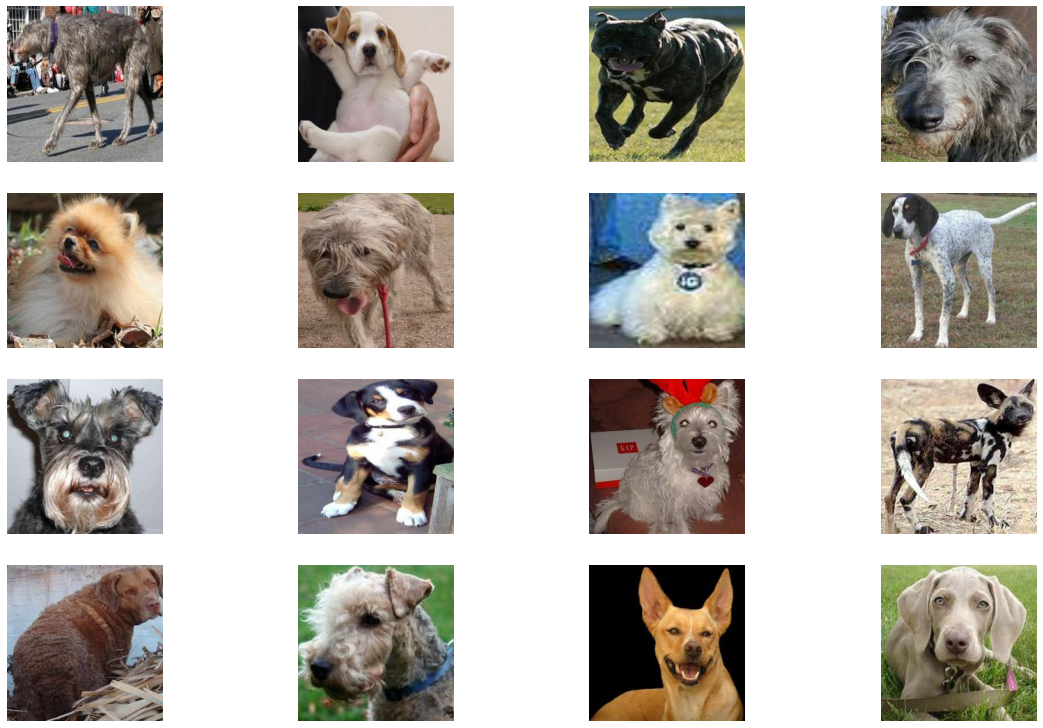

In [31]:
## What are the dog image sizes. 
## Les tailles d'images sont différentes, dans certaines images il y plus qu'un chien.
def showImages(files_list, col=10, wSize=5, hSize=5, mypath='.'):
    fig = figure(figsize=(wSize, hSize))
    number_of_files = len(files_list)
    row = 5
    if (number_of_files % col != 0):
        row += 1
    for i in range(row+10):
        a=fig.add_subplot(row, col, i + 1)
        img = imread(files_list[i])
        imshow(img)
        axis('off')
        
        
showImages(train_files, wSize=20, hSize=20, col=4)

In [13]:
## Fonction d'affichage de la répartition des images par races
def plot_breed_distribution(df, train):
    labels = []
    #récupération de la race de chaque image
    for i in range(df.shape[0]):
        labels.append(dog_names[np.argmax(df[i])])
        
    #création de l'histogramme
    df_labels = pd.DataFrame(np.array(labels), columns=["races"]).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10,30))
    df_labels['races'].value_counts().plot(ax=ax, kind='barh')
    ax.set_title('Repartition des races pour l entrainement et la validation')  
    


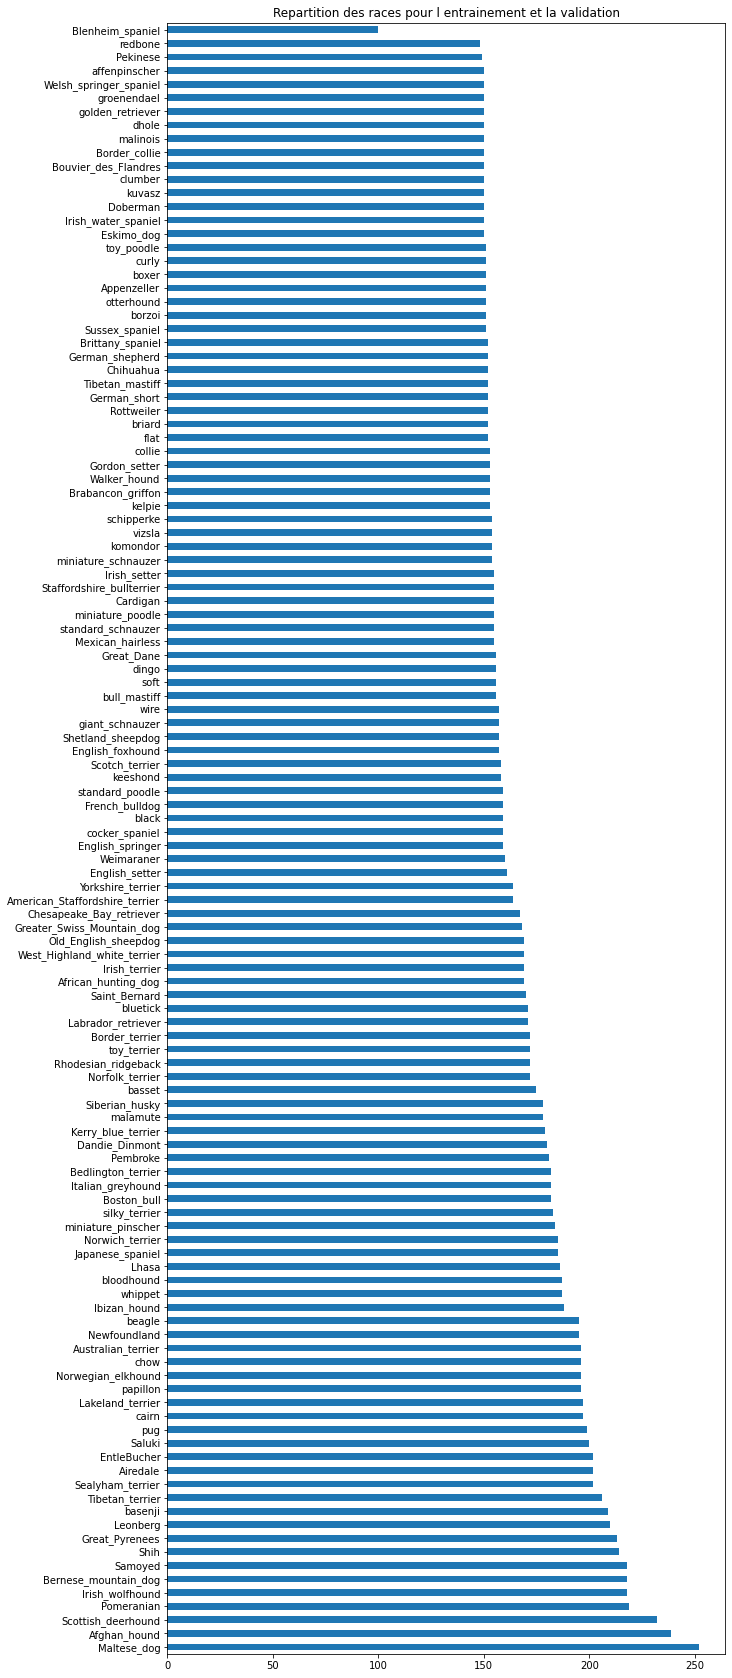

In [15]:
# Répartition des races pour l'entrainement
plot_breed_distribution(train_targets, True)

In [22]:
#récupération de la race de chaque image d'entrainement
train_ = []
for i in range(train_files.shape[0]):
    train_.append(dog_names[np.argmax(train_targets[i])])
  
    
## Distribution des races
def breed_distribution(dogs, train):
    encoder = LabelEncoder()
    breeds_encoded = encoder.fit_transform(dogs)
    n_classes = len(encoder.classes_)
    
    breeds = pd.DataFrame(np.array(breeds_encoded), columns=["race"]).reset_index(drop=True)
    breeds['freq'] = breeds.groupby('race')['race'].transform('count')
    avg = breeds.freq.mean()
    
    title = 'Distribution des races\n'

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_xticks([])
    
    ax.hlines(avg, 0, n_classes - 1, color='red')
    ax.set_title(title, fontsize=18)
    _ = ax.hist(breeds_encoded, bins=n_classes)
    
    return(breeds["freq"].describe())

count    20477.000000
mean       173.986082
std         25.103987
min        100.000000
25%        153.000000
50%        168.000000
75%        195.000000
max        252.000000
Name: freq, dtype: float64

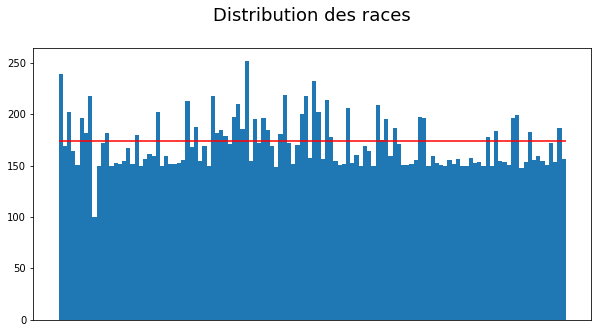

In [23]:
breed_distribution(train_, True)